In [ ]:
# run this cell if using colab
from google.colab import drive
drive.mount('/content/drive')

%cp -r /content/drive/MyDrive/mm_nn/methods /content/
%cp -r /content/drive/MyDrive/mm_nn/train.h5 /content/
%cp -r /content/drive/MyDrive/mm_nn/test.h5 /content/
%cp -r /content/drive/MyDrive/mm_nn/params.yaml /content/

%pip install wandb
%pip install torchinfo

In [1]:
import torch
from torch import Tensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torchinfo import summary

import wandb
import random

import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm.notebook import tqdm
from datetime import datetime

from methods.base import BaseConfig
from methods.plotting import plot_perm, plot_press, plot_event_list, plot_events_projection

import os
from pathlib import Path

CURR_DIR = os.getcwd()
train_h5_path = f'{CURR_DIR}/train.h5'
test_h5_path = f'{CURR_DIR}/test.h5'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


c:\!Work\Projects\nn_for_mm\.venv\Lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Data retrieving example

Permeability map


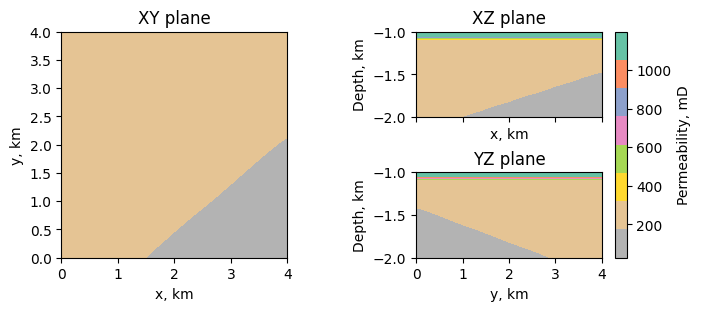

Pore pressure at the fimal step


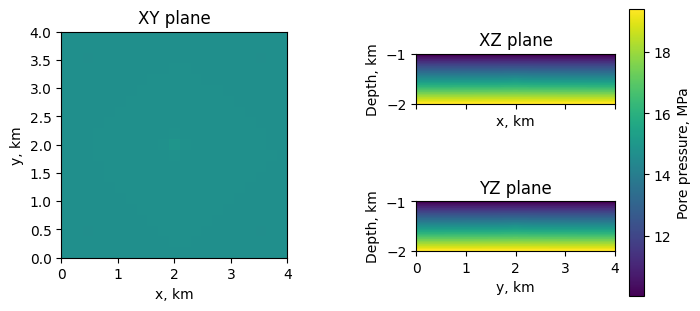

Events
Seismic density at the fimal step


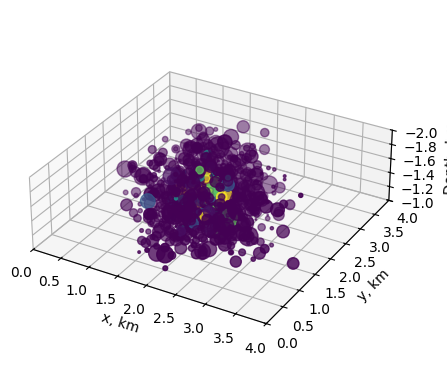

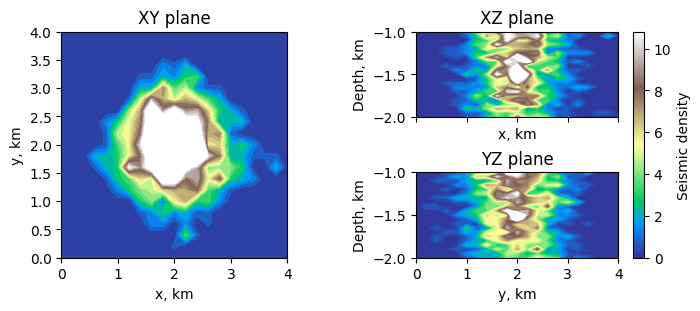

Pore pressure at the fimal step at source location slice


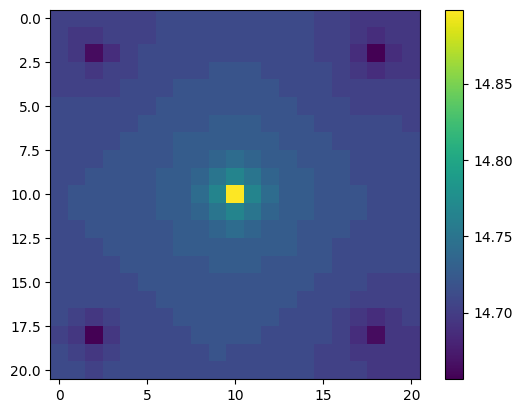

In [2]:
jj = 42 

with h5py.File(train_h5_path, 'a') as f:
    ev = f['events'][jj]
    pp = f['perm'][jj]
    pore = f['pore'][jj]
    ev_d = f['ev_dens'][jj]

params = BaseConfig()
params.load() # loading params from params.yaml

print('Permeability map')
plot_perm(pp, loc=(10, 10, 10), params=params)

print('Pore pressure at the fimal step')
plot_press(pore, loc=(10, 10, 10), params=params)

print('Events')
plot_event_list(ev[0:900], params=params)

print('Seismic density at the fimal step')
plot_events_projection(ev_d, params=params)

print('Pore pressure at the fimal step at source location slice')
fig, ax = plt.subplots()
ims = ax.imshow(pore[:,:,10]) # pore press at source location slice
plt.colorbar(ims, ax=ax)

### model 

In [2]:
# Dataset Class -------------------------------------------------------
class EventsToPermDataset(torch.utils.data.Dataset):

    def __init__(self, h5_path, transforms):
        super().__init__()
        self.path = h5_path
        self.transforms = self.stack_transforms(transforms) # transforms func
        with h5py.File(h5_path, 'a') as f:
            nmodels = f['events'].shape[0]
        self.nmodels = nmodels

    def __getitem__(self, idx):
        with h5py.File(self.path, 'a') as f:
            event = f['events'][idx]
            perm = f['perm'][idx]

        return self.transforms(event, perm)

    def __len__(self):
        return self.nmodels

    def stack_transforms(self, func_list):
        def performer(*args):
            for f in func_list:
                args = f(*args)
            return args
        return performer

class Normalizer:
    ''' returns log10(perm)     '''
    def __call__(self, events, perms):
        log_perm = torch.log10(perms)
        return events, log_perm

class ToTensor:
    '''Transforms numpy to torch tensors'''
    def __call__(self, events, perms):
        perms = torch.Tensor(perms)
        events = torch.Tensor(events)
        return events, perms

# Custom losses ---------------------------------------------------------

class MaskedL1Loss(nn.Module):
    # masked loss for better event handeling: no events - no results 
    def __init__(self, mask):
        super().__init__()
        self.base_loss = torch.nn.L1Loss(reduction='none')
        self.mask = mask

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        masked_loss = self.mask * self.base_loss(input, target)
        return torch.mean(masked_loss)
    
class MaskedMSELoss(nn.Module):
    # masked loss for better event handeling: no events - no results 
    def __init__(self, mask):
        super().__init__()
        self.base_loss = torch.nn.MSELoss(reduction='none')
        self.mask = mask

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        masked_loss = self.mask * self.base_loss(input, target)
        return torch.mean(masked_loss)

# model modules ---------------------------------------------------------

class EventListTransformerEncoder(nn.Module):
    '''
    Performs attention over the List of events
    '''
    def __init__(self, emb_size, num_layers, nheads):
        super().__init__()
        self.emb_size = emb_size
        self.num_layers = num_layers
        self.nheads = nheads
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = self.emb_size, nhead = self.nheads, batch_first=True) # one head. emb size is unpredictable
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, self.num_layers)

    def forward(self, x):
        x = self.transformer_encoder(x)
        return x

class Fc(nn.Module):
    '''
    universal Fc layer inp_size - > target size via num_layers
    '''
    def __init__(self, inp_size, target_size, num_layers, flat=False, fc_drop=0):
        super().__init__()
        self.target_size = target_size
        self.layers = self.create_layers(inp_size, target_size, num_layers, flat)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(fc_drop)

    def create_layers(self, inp, outp, nlayers, flat):
        if flat:
            sizes = [inp] + [outp for ii in range(nlayers)]
        else:
            mult = (outp/inp)**(1/nlayers)
            sizes = [int(inp*mult**ii) for ii in range(nlayers)]
            sizes.append(outp)

        layers = [nn.Linear(sizes[ii], sizes[ii+1]) for ii in range(nlayers)]
        return nn.ModuleList(layers)

    def forward(self, x):
        bs = x.shape[0] # batch size
        x = x.flatten(0, 1)
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))
        x = self.layers[-1](x)
        x = x.view(bs, -1, self.target_size)
        return x
    
class Upconv(nn.Module):
    '''
    universal Fc layer inp_size - > target size via num_layers
    '''
    def __init__(self, event_num, small_cube_side, target_shape):
        super().__init__()
        self.small_cube_side = small_cube_side
        self.event_num = event_num
        self.target_shape = target_shape # no need now
        self.relu = nn.LeakyReLU(0.01)

        self.upconv_1 = nn.ConvTranspose3d(self.event_num, 256, kernel_size = 3, stride = 2, padding = 0, output_padding = 0)
        self.upconv_2 = nn.ConvTranspose3d(256, 32, kernel_size = 3, stride = 2,  padding = 0, output_padding = 0)
        self.upconv_3 = nn.ConvTranspose3d(32, 16, kernel_size = 3, stride = 1,  padding = 0, output_padding = 0)
        self.upconv_4 = nn.ConvTranspose3d(16, 8, kernel_size = 3, stride = 1,  padding = 0, output_padding = 0)
        self.upconv_5 = nn.ConvTranspose3d(8, 1, kernel_size = 3, stride = 1,  padding = 0, output_padding = 0)


    def forward(self, x):
        bs = x.shape[0] # batch size
        x = x.view(bs, -1, self.small_cube_side, self.small_cube_side, self.small_cube_side) # small cubes
        x = self.relu(self.upconv_1(x))
        x = self.relu(self.upconv_2(x))
        x = self.relu(self.upconv_3(x))
        x = self.relu(self.upconv_4(x))
        x = self.upconv_5(x)
        x = x.squeeze(1)
        return x
    
class EventsToPermUpconv(nn.Module):
    '''
    Model itself
    list of events -> permeability map
    '''
    def __init__(self, params):
        super().__init__()
        self.input_shape = (1100, 5)
        self.target_shape = (21, 21, 21)
        self.inp_size = self.input_shape[1] # 5
        self.event_num = self.input_shape[0] # 1100
        self.small_cube_side = params.small_cube_side
        self.emb_size = self.small_cube_side ** 3

        self.embed = Fc(inp_size = self.inp_size, target_size = self.emb_size, num_layers = params.embed_num_layers, flat=params.flat, fc_drop = 0.0)
        self.encoder = EventListTransformerEncoder(emb_size = self.emb_size, num_layers = params.encoder_num_layers, nheads = params.nheads)
        self.upconv = Upconv(event_num = self.event_num,  small_cube_side = self.small_cube_side, target_shape = self.target_shape)

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        x = self.upconv(x)
        return x

# Net class with training evaluating and other---------------------------------------------------------- 

class PermNet:
    def __init__(self, train_h5_path, test_h5_path, train_params):
        self.params = train_params
        self.device = self.params.device
        self.train_dl, self.test_dl = self.create_dl(train_h5_path, test_h5_path)
        self.model = EventsToPermUpconv(self.params)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params.lr)
        self.mask = self.get_ev_dens_mask(train_h5_path)
        self.loss = MaskedMSELoss(self.mask)

    def __call__(self, X):
        self.model.to(self.device).eval()
        X = X.to(self.device)
        with torch.no_grad():
            y_hat = self.model(X).cpu()
        self.model.to("cpu")
        return y_hat

    def evaluate(self):
        val_loss = []
        self.model.to(self.device).eval()
        for X, y in self.test_dl:
            X, y = X.to(self.device), y.to(self.device)
            with torch.no_grad():
                y_hat = self.model(X)
            l = self.loss(y_hat, y)
            val_loss.append(l.item())
        self.model.to("cpu")
        return torch.mean(torch.tensor(val_loss)).item()

    def train(self):
        self.metrics = {'loss':{'train': [], 'val': []}, 'epoch': []}
        for epoch in tqdm(range(self.params.epochs)):
            losses = self.train_one_epoch()
            self.metrics['epoch'].append(epoch)
            self.metrics['loss']['train'].append(losses['train'])
            self.metrics['loss']['val'].append(losses['val'])
            if epoch % 1 == 0:
                print(f"Epoch {epoch}:: train loss: {self.metrics['loss']['train'][-1]:.04f}, val loss: {self.metrics['loss']['val'][-1]:.04f}")
        return self.metrics

    def train_one_epoch(self):
        self.model.to(self.device).train()
        for X, y in tqdm(self.train_dl):
            X, y = X.to(self.device), y.to(self.device)
            y_hat = self.model(X)
            l = self.loss(y_hat, y)
            self.optimizer.zero_grad()
            l.backward()
            self.optimizer.step()
        losses = {'train': l.item(), 'val': self.evaluate()}
        self.model.to("cpu")
        return losses

    def create_dl(self, train_h5_path, test_h5_path):
        # creates dataloaders
        transforms = [ToTensor(), Normalizer(),] # data transformations

        train = EventsToPermDataset(h5_path = train_h5_path, transforms=transforms)
        test = EventsToPermDataset(h5_path = test_h5_path, transforms=transforms)

        train_dl = DataLoader(dataset=train,
                            batch_size=self.params.batch_size,
                            shuffle=True,
                            )

        test_dl = DataLoader(dataset=test,
                            batch_size=self.params.batch_size,
                            shuffle=False,
                            )

        return train_dl, test_dl

    def get_ev_dens_mask(self, train_h5_path, eps=1e-3):
        with h5py.File(train_h5_path, 'a') as f:
            ev_d = f['ev_dens'][:]
            mean_ev_d = np.mean(ev_d, axis=0)
            mask = mean_ev_d/np.max(mean_ev_d)
            mask[mask<eps] = eps
        
        return torch.tensor(mask).to(self.device)

    def plot_metrics(self):
        fig, ax = plt.subplots(figsize=(4.33, 3))
        ax.plot(self.metrics['epoch'], self.metrics['loss']['train'], label='train')
        ax.plot(self.metrics['epoch'], self.metrics['loss']['val'],  label='val')
        ax.set_title('Loss', loc='center', fontsize=12)
        ax.set_xlabel('# Epoch', fontsize=12)
        ax.legend()

    def print_summary(self):
        print(summary(self.model, input_size=(1,) + self.params.input_shape))
        
    def get_weights(self):
        return self.model.state_dict()

    def set_weights(self, state_dict):
        self.model.load_state_dict(state_dict)

    def load_weights(self, pt_path):
        self.model.load_state_dict(torch.load(pt_path)) 

    def save(self, state_name=''):
        Path(f'{CURR_DIR}/model_states/').mkdir(parents=True, exist_ok=True)
        pt_path = f'{CURR_DIR}/model_states/{state_name}{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}.pt'
        torch.save(self.model.state_dict(), pt_path)

# train config class ------------------------------------------------------------

class TrainConfig:
    def __init__(self, **kwargs):
        # embed layer params
        self.embed_num_layers = 5
        self.flat = True

        # small cube
        self.small_cube_side = 3
        
        # encoder params
        self.encoder_num_layers = 2
        self.nheads = 1
        
        # training params
        self.batch_size = 60
        self.epochs = 35
        self.lr = 0.0001

        # device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # kwargs to attrs
        self.__dict__.update(kwargs)

    def __repr__(self) -> str:
        return str(self.__dict__)

### Training and Tuning

In [4]:
# tune proc
# wandb.login()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

def trial_my_net(project, group, config):
    train_params = TrainConfig(**config)
    trial_id = f'trial_{datetime.now().strftime("%m_%d_%Y__%H_%M_%S")}'
    to_wandb = {'trial': trial_id}
    to_wandb.update(train_params.__dict__)
    
    net = PermNet(train_h5_path, test_h5_path, train_params)
    
    with wandb.init(project=project, group=group, config=to_wandb):
        for epoch in range(train_params.epochs):
            losses = net.train_one_epoch()
            wandb.log(losses)
            net.save(f'trial_{trial_id}__epoch{epoch}__') # saving model state

    # net.plot_metrics()
    # net.save(f'{trial_id}__final__') # saving model state


In [ ]:
# general training
wandb.login()

conf = {'epochs' : 35, 'batch_size' : 60}
trial_my_net(project='test_project', group='general_training',  config=conf)

#### it works?

c:\!Work\Projects\nn_for_mm\.venv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Ground truth Permeability map


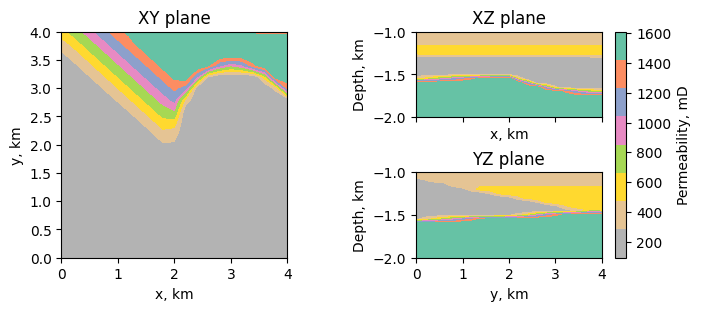

Model Permeability map


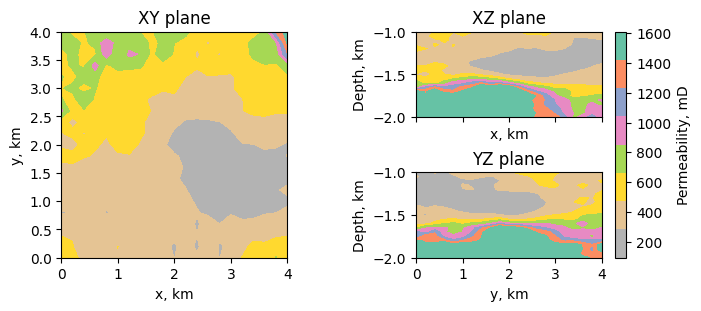

In [3]:
jj = 310

transforms = [ToTensor(), Normalizer(),] # data transformations
test = EventsToPermDataset(h5_path = test_h5_path, transforms=transforms)

train_params = TrainConfig() # old weigts with 10 encoder layers and nonflat version of FC --> model states/06_10_2024__19_11_56.pt
net = PermNet(train_h5_path, test_h5_path, train_params)
net.load_weights('model_states/trial_trial_06_19_2024_10_20_22_epoch31_06_19_2024_19_55_27.pt')

x, y = test[jj]

y = y.numpy()
x = x.unsqueeze(0)
y_hat = net(x).squeeze(0).detach().numpy()

params = BaseConfig()
params.load() # loading params from params.yaml

# vmin_vmax = (10**np.min(np.minimum(y, y_hat)), 10**np.max(np.maximum(y, y_hat))) # for same norms
vmin_vmax = (10**np.min(y), 10**np.max(y)) # for same norms

print('Ground truth Permeability map')
plot_perm(10**y, loc=(10, 10, 10), params=params, vmin_vmax=vmin_vmax)

print('Model Permeability map')
plot_perm(10**y_hat, loc=(10, 10, 10), params=params, vmin_vmax=vmin_vmax)

### Кастомные Рисовалки


In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_errors(data, loc, params, vmin_vmax=None, save=False, fname='err'):
    cmap = mpl.cm.plasma
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig = plt.figure(figsize=(7, 3), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    ax1 = subfigs[0].subplots()
    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=ax1)

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=10)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ticks = [0,1,2,3,4]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=10)
    ax2.set_title('XZ plane')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=10)
    ax3.set_title('YZ plane')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=(ax2, ax3), orientation='vertical', label='Mean relative error')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()


def plot_lognorm_sigma(data, loc, params, vmin_vmax=None, save=False, fname='lognorm_err'):
    cmap = mpl.cm.plasma
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig = plt.figure(figsize=(7, 3), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    ax1 = subfigs[0].subplots()
    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=ax1)

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=10)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ticks = [0,1,2,3,4]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=10)
    ax2.set_title('XZ plane')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=10)
    ax3.set_title('YZ plane')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=(ax2, ax3), orientation='vertical', label=r'$\sigma_{log(y-\^y)},\ [log(mD)]$')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()


def plot_perm(data, loc, params, vmin_vmax=None, save=False, fname='permeability'):

    data = data/1000 # Perm in Darcy

    cmap = mpl.cm.Set2_r
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0]/1000, vmax=vmin_vmax[1]/1000) # Darcy => .../1000 

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig = plt.figure(figsize=(7, 3), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    ax1 = subfigs[0].subplots()
    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=ax1)

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=100)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')
    
    ticks = [0,1,2,3,4]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax2.set_title('XZ plane')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax3.set_title('YZ plane')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              ax=(ax2, ax3), anchor=(0, 0.5), shrink=1, orientation='vertical', label='Permeability, D')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()

def plot_press_plan(data, loc, params, vmin_vmax=None, save=False, fname='Pore pressure'):
    # horizontal plan only 

    pore_press = data[:, :, loc[2]]

    cmap = mpl.cm.viridis
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(pore_press), vmax=np.max(pore_press))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])
        # norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig, ax1 = plt.subplots(figsize=(7, 3), layout="constrained")

    ax1.imshow(pore_press.transpose(), extent=[x_ax[0], x_ax[-1], y_ax[0], y_ax[-1]], origin='lower', cmap=cmap, norm=norm) 
    # ax1.contourf(x_ax, y_ax, pore_press.transpose(), cmap=cmap, norm=norm, levels=20)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ticks = [0,1,2,3,4]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax1, orientation='vertical', label='Pore pressure, MPa')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()


def plot_ev_dens_slice(data, loc, params, vmin_vmax=None, save=False, fname='seism_dens'):

    data = data/np.prod(params.dx_dy_dz) # events per m3

    cmap = mpl.cm.terrain
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig = plt.figure(figsize=(7, 3), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    ax1 = subfigs[0].subplots()
    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=ax1)

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=100)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ticks = [0,1,2,3,4]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax2.set_title('XZ plane')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax3.set_title('YZ plane')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=(ax2, ax3), orientation='vertical', label=r'Seismic events in $m^3$')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()
   

def plot_event_list(ev_list, params, vmin_vmax=None, save=False, fname='events in space time and mag', title=None):

    fig = plt.figure(figsize=(11, 4), layout="constrained") #, dpi=300)

    ax = fig.add_subplot(projection='3d')

    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(ev_list[:,0]), vmax=np.max(ev_list[:,0]))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0], vmax=vmin_vmax[1])
    
    cmap = mpl.cm.viridis_r

    t, x, y, d, M = [ev_list[:, ii] for ii in range(ev_list.shape[-1])]
    x_m, y_m, d_m = [dxdydz * xyz for dxdydz, xyz in zip(params.dx_dy_dz, [x, y, d])]
    x_km, y_km, d_km = [(bound[0] + xyz)/1000 for bound, xyz in zip(params.sides, [x_m, y_m, d_m])]

    scatter = ax.scatter(x_km, y_km, - d_km, marker='o', c=t, cmap=cmap, norm=norm, s=(5*M)**2, label='event')
    # ax.set_aspect('equal')
    ax.set_xlabel('x, km')
    ax.set_ylabel('y, km')
    ax.set_zlabel('Depth, km')
    ax.set_xlim(1e-3*np.array(params.sides[0]))
    ax.set_ylim(1e-3*np.array(params.sides[1]))
    ax.set_zlim(-1e-3*np.array(params.sides[2]))
    ax.invert_zaxis()

    ax.set_xticks([0,1,2,3,4])
    ax.set_yticks([0,1,2,3,4])
    ax.set_zticks([-1, -1.5, -2])
    if title:
        ax.set_title(title)

    # produce a legend with a cross-section of sizes from the scatter
    m_handles = [
        mpl.lines.Line2D([], [], color=cmap(norm(60)), marker='o', linestyle='None', markersize=5*1, alpha=0.6, label='1'), # markersize=sqrt(s) from scatter
        mpl.lines.Line2D([], [], color=cmap(norm(60)), marker='o', linestyle='None', markersize=5*2, alpha=0.6, label='2'),
        mpl.lines.Line2D([], [], color=cmap(norm(60)), marker='o', linestyle='None', markersize=5*3, alpha=0.6, label='3'),
        ]

    m_legend = fig.legend(handles = m_handles, loc=(0.63, 0.6), title= "M")
    fig.colorbar(scatter, location='bottom', label='Time, h',  shrink=0.2)

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()


def plot_masked_perm(data, mask, loc, params, vmin_vmax=None, save=False, fname='masked permeability'):

    data = data/1000 # Perm in Darcy
    data[mask==0] = np.nan # masking

    cmap = mpl.cm.Set2_r
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0]/1000, vmax=vmin_vmax[1]/1000) # Darcy => .../1000 
        # norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig = plt.figure(figsize=(7, 3), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    ax1 = subfigs[0].subplots()
    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=ax1)

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=100, corner_mask=True)
    ax1.contour(x_ax, y_ax, mask[:, :, loc[2]].transpose(), colors='k', levels=[0.999,], linewidths=0.5) # contour for mask
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')
    ax1.set_xlim([1.2, 2.8])
    ax1.set_ylim([1.2, 2.8])

    ticks = [1.5, 2, 2.5]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    
    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=100, corner_mask=True)
    ax2.contour(x_ax, -z_ax, mask[:, loc[1], :].transpose(), colors='k', levels=[0.999,], linewidths=0.5)
    ax2.set_title('XZ plane')
    # ax2.set_aspect('equal')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')
    ax2.set_xlim([1, 3])
    ax2.set_ylim([-1.8, -1.15])

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=100, corner_mask=True)
    ax3.contour(y_ax, -z_ax, mask[loc[0], :, :].transpose(), colors='k', levels=[0.999,], linewidths=0.5)
    ax3.set_title('YZ plane')
    # ax3.set_aspect('equal')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')
    ax3.set_xlim([1, 3])
    ax3.set_ylim([-1.8, -1.15])

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              ax=(ax2, ax3), anchor=(0, 0.5), shrink=1, orientation='vertical', label='Permeability, D')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()


def plot_perm_with_contour(data, mask, loc, params, vmin_vmax=None, save=False, fname='masked permeability'):

    data = data/1000 # Perm in Darcy

    cmap = mpl.cm.Set2_r
    if vmin_vmax is None:
        norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.Normalize(vmin=vmin_vmax[0]/1000, vmax=vmin_vmax[1]/1000) # Darcy => .../1000 

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig = plt.figure(figsize=(7, 3), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    ax1 = subfigs[0].subplots()
    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=ax1)

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=100)
    ax1.contour(x_ax, y_ax, mask[:, :, loc[2]].transpose(), colors='k', levels=[0.999,]) # contour for mask
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ticks = [0,1,2,3,4]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax2.contour(x_ax, -z_ax, mask[:, loc[1], :].transpose(), colors='k', levels=[0.999,])
    ax2.set_title('XZ plane')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=100)
    ax3.contour(y_ax, -z_ax, mask[loc[0], :, :].transpose(), colors='k', levels=[0.999,])
    ax3.set_title('YZ plane')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              ax=(ax2, ax3), anchor=(0, 0.5), shrink=1, orientation='vertical', label='Permeability, D')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()

def plot_loss_mask(data, loc, params, vmin_vmax=None, save=False, fname='loss mask'):
    cmap = mpl.cm.cool
    if vmin_vmax is None:
        # norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
        norm = mpl.colors.LogNorm(vmin=np.min(data), vmax=np.max(data))
    else:
        norm = mpl.colors.LogNorm(vmin=vmin_vmax[0], vmax=vmin_vmax[1])

    x_ax, y_ax, z_ax = (np.linspace(s[0], s[1], sh)/1000 for sh, s in zip(params.shape, params.sides))  # km

    fig = plt.figure(figsize=(7, 3), layout="constrained")
    subfigs = fig.subfigures(1, 2)
    ax1 = subfigs[0].subplots()
    (ax2, ax3) = subfigs[1].subplots(2, 1, sharex=ax1)

    ax1.contourf(x_ax, y_ax, data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm, levels=[0.001, 0.01, 0.1, 0.5, 1])
    # ax1.imshow(data[:, :, loc[2]].transpose(), cmap=cmap, norm=norm)
    ax1.set_title('XY plane')
    ax1.set_aspect('equal')
    ax1.set_xlabel('x, km')
    ax1.set_ylabel('y, km')

    ticks = [0,1,2,3,4]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)

    ax2.contourf(x_ax, -z_ax, data[:, loc[1], :].transpose(),  cmap=cmap, norm=norm, levels=[0.001, 0.01, 0.1, 0.5, 1])
    ax2.set_title('XZ plane')
    ax2.set_xlabel('x, km')
    ax2.set_ylabel('Depth, km')

    ax3.contourf(y_ax, -z_ax, data[loc[0], :, :].transpose(),  cmap=cmap, norm=norm, levels=[0.001, 0.01, 0.1, 0.5, 1])
    ax3.set_title('YZ plane')
    ax3.set_xlabel('y, km')
    ax3.set_ylabel('Depth, km')

    # колорбар
    plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=(ax2, ax3), orientation='vertical', label='Loss mutiplicator')

    if save:
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)

    plt.show()

def plot_error_vs_event_num(evs, errs):
    x = evs.flatten()
    y = errs.flatten()

    fig, ax = plt.subplots(figsize=(4,3))
    ax.scatter(x, y, marker='+')
    ax.set_xscale('log')
    ax.set_ylim([0, 0.5])
    ax.set_xlim([1e-1, 100])

    coef = np.polyfit(np.log(x[x>2e-1]), y[x>2e-1], 1)
    poly1d_fn = np.poly1d(coef) 
    xx = np.array([0.1, 100])
    plt.plot(xx, poly1d_fn(np.log(xx)), c='r', linestyle=':', linewidth=2)

    ax.set_xlabel('Количество событий')
    ax.set_ylabel('Ошибка порядка определения')


def event_pics_for_gif(ev, params):
    np.random.seed(42)
    Path(f'{CURR_DIR}/pics/').mkdir(parents=True, exist_ok=True)
    timestamp = datetime.now().strftime("%m_%d_%Y__%H_%M_%S")
    
    max_time = int(np.max(ev[:,0])) # last event
            
    fig = plt.figure(figsize=(11, 4), layout="constrained") #, dpi=300)
    ax = fig.add_subplot(projection='3d')
    norm = mpl.colors.Normalize(0, max_time)
    cmap = mpl.cm.viridis_r

    ax.set_xlabel('x, km')
    ax.set_ylabel('y, km')
    ax.set_zlabel('Depth, km')
    ax.set_xlim(1e-3*np.array(params.sides[0]))
    ax.set_ylim(1e-3*np.array(params.sides[1]))
    ax.set_zlim(-1e-3*np.array(params.sides[2]))
    ax.invert_zaxis()

    ax.set_xticks([0,1,2,3,4])
    ax.set_yticks([0,1,2,3,4])
    ax.set_zticks([-1, -1.5, -2])
    
    # produce a legend with a cross-section of sizes from the scatter
    m_handles = [
        mpl.lines.Line2D([], [], color=cmap(norm(60)), marker='o', linestyle='None', markersize=5*1, alpha=0.6, label='1'), # markersize=sqrt(s) from scatter
        mpl.lines.Line2D([], [], color=cmap(norm(60)), marker='o', linestyle='None', markersize=5*2, alpha=0.6, label='2'),
        mpl.lines.Line2D([], [], color=cmap(norm(60)), marker='o', linestyle='None', markersize=5*3, alpha=0.6, label='3'),
        ]
    fig.legend(handles = m_handles, loc=(0.63, 0.6), title= "M")

    sc = ax.scatter([0],[0],[0], c=max_time, cmap=cmap, norm=norm, s=0,)
    plt.colorbar(sc, location='bottom', label='Time, h',  shrink=0.2)

    t, x, y, d, M = [ev[:, ii] for ii in range(ev.shape[-1])]
    x_m, y_m, d_m = [dxdydz * xyz for dxdydz, xyz in zip(params.dx_dy_dz, [x, y, d])]
    x_km, y_km, d_km = [(bound[0] + xyz)/1000 for bound, xyz in zip(params.sides, [x_m, y_m, d_m])]
    
    
    for hh in range(max_time):
        title = f'Time = {hh} h'
        step = t.astype('int') == hh
        if True in step:
            ax.scatter(x_km[step], y_km[step], - d_km[step], marker='o', c=t[step], cmap=cmap, norm=norm, s=(5*M[step])**2, label='event')
        
        ax.set_title(title)
        
        fname = f'{CURR_DIR}/pics/h_{hh}_{timestamp}'        
        plt.savefig(f'{fname}.png', dpi = 300,  bbox_inches='tight', transparent=False)


### Plotting it all

Ground truth Permeability map


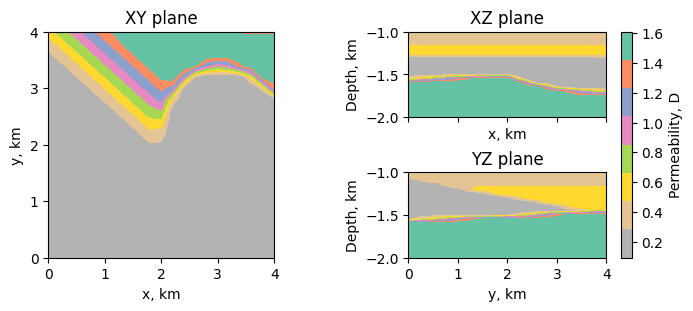

Model Permeability map


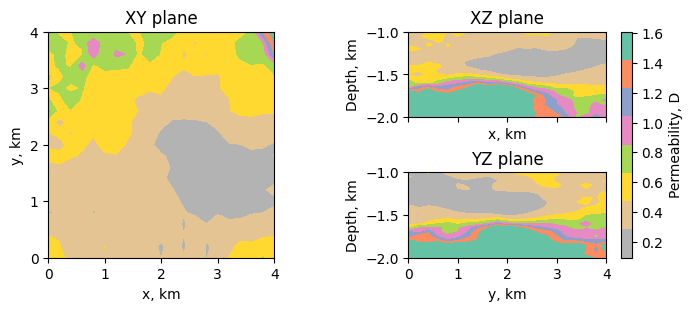

Pore pressure at the fimal step


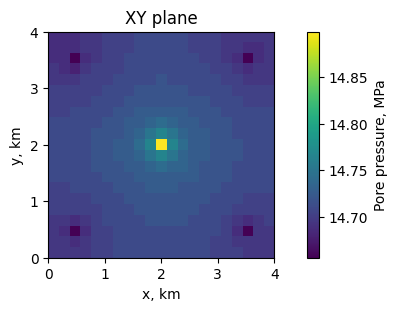

Events


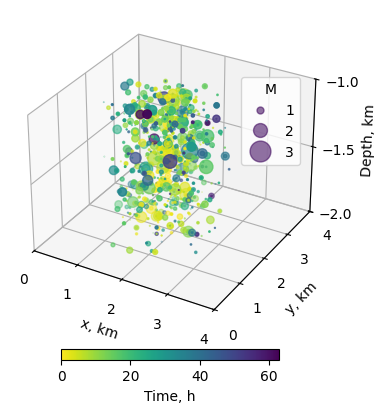

Seismic events in m3


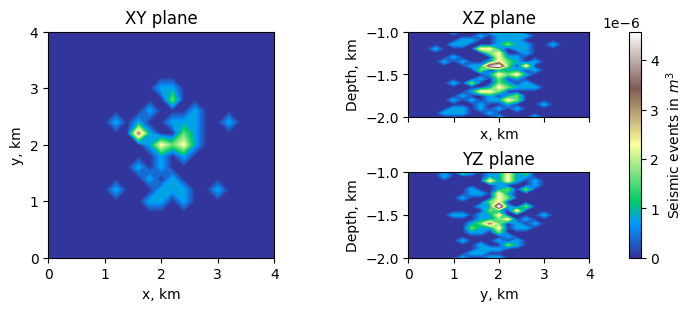

In [61]:
jj = 310

# net setup
transforms = [ToTensor(), Normalizer(),] # data transformations
test = EventsToPermDataset(h5_path = test_h5_path, transforms=transforms)
train_params = TrainConfig(batch_size = 200) # batch_size for error testing
net = PermNet(train_h5_path, test_h5_path, train_params)
net.load_weights('model_states/trial_trial_06_19_2024_10_20_22_epoch31_06_19_2024_19_55_27.pt')

# data sampl
with h5py.File(test_h5_path, 'a') as f:
    ev = f['events'][jj]
    # perm = f['perm'][jj]
    pore = f['pore'][jj]
    ev_d = f['ev_dens'][jj] # all events at final step, np.sum(ev_d) = 1000 events total

loc=(10, 10, 10)
params = BaseConfig()
params.load()

x, y = test[jj]

y = y.numpy()
x = x.unsqueeze(0)
y_hat = net(x).squeeze(0).detach().numpy()

params = BaseConfig()
params.load() # loading params from params.yaml

# vmin_vmax = (10**np.min(np.minimum(y, y_hat)), 10**np.max(np.maximum(y, y_hat))) # for same norms
vmin_vmax = (10**np.min(y), 10**np.max(y)) # for same norms

print('Ground truth Permeability map')
plot_perm(10**y, loc, params, vmin_vmax=vmin_vmax)

print('Model Permeability map')
plot_perm(10**y_hat, loc, params, vmin_vmax=vmin_vmax)

print('Pore pressure at the fimal step')
plot_press_plan(pore, loc, params)

print('Events')
plot_event_list(ev[0:980], params=params)

print('Seismic events in m3')
plot_ev_dens_slice(ev_d, loc, params)


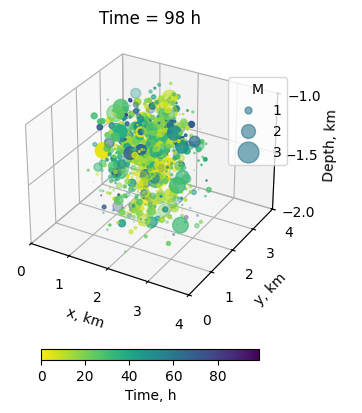

In [298]:
# events fo gif
event_pics_for_gif(ev, params)

In [10]:
# lognorm_sigma = np.zeros(params.shape)
lognorm_sigma_list = []

for ii, (X, y) in enumerate(tqdm(net.test_dl)):
    y_hat = net(X)
    diff = (y - y_hat).detach().cpu().numpy()
    std_diff = diff.std(axis=0)
    lognorm_sigma_list += [std_diff,]

# lognorm_sigma = lognorm_sigma/(ii+1) # ii+1 batches
# mean_relative_perm_error = 10**lognorm_sigma - 1
lognorm_sigma = np.mean(np.array(lognorm_sigma_list), axis=0)
mean_relative_perm_error = 10**lognorm_sigma - 1

  0%|          | 0/69 [00:00<?, ?it/s]

Permeability relative error map


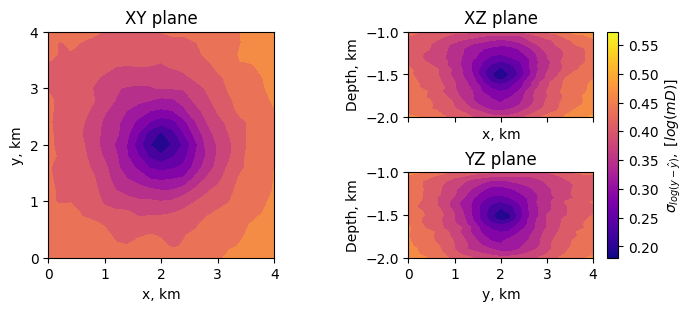

Permeability relative error map


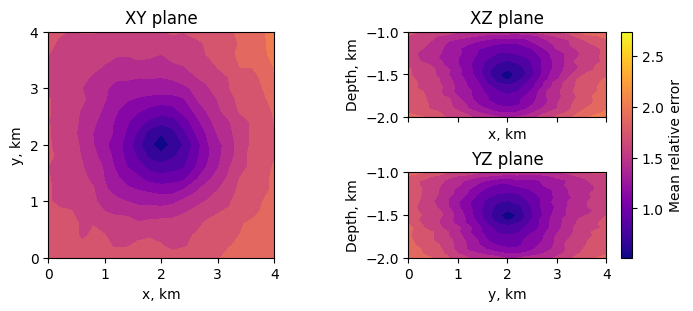

Loss mask


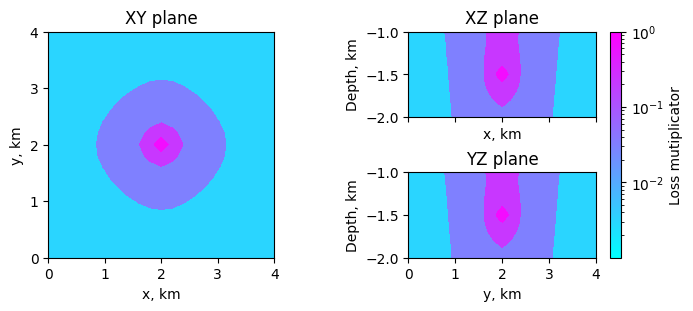

In [37]:

print('Permeability relative error map')
plot_lognorm_sigma(lognorm_sigma, loc, params)


print('Permeability relative error map')
plot_errors(mean_relative_perm_error, loc, params)

print('Loss mask')
plot_loss_mask(net.mask.detach().cpu().numpy(), loc, params)

Ground truth Permeability map


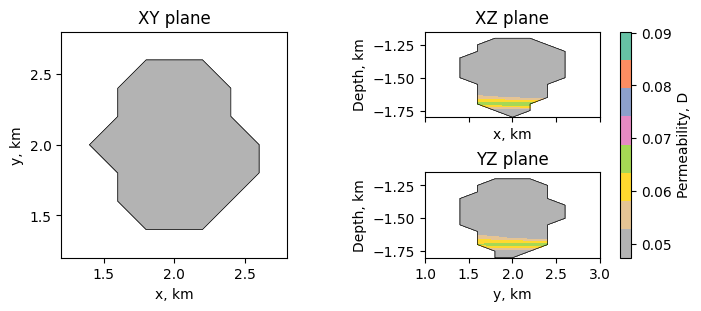

Masked Model Permeability map


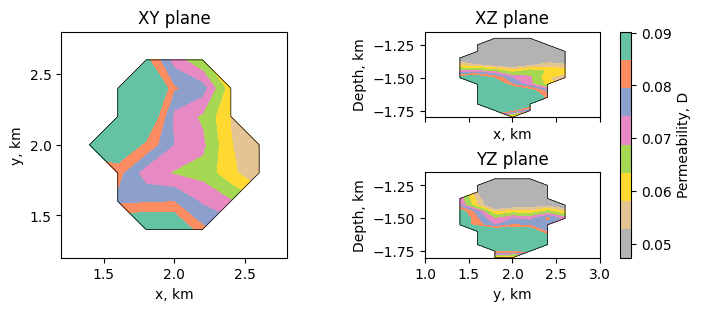

Ground truth Permeability map


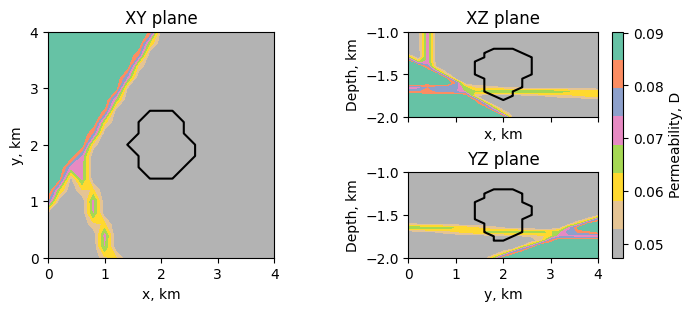

Masked Model Permeability map


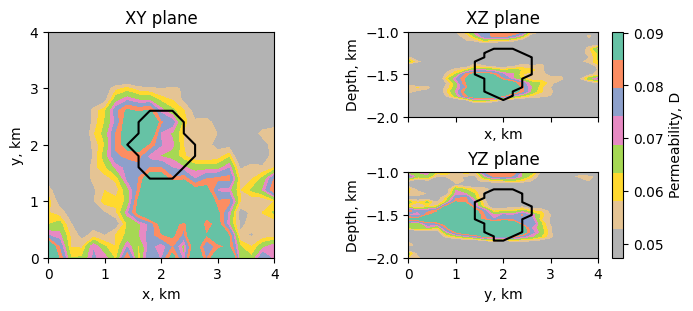

In [54]:
# mask for plotting
mask = np.ones_like(lognorm_sigma)
mask[lognorm_sigma > np.log10(2)] = 0

print('Ground truth Permeability map')
plot_masked_perm(10**y, mask, loc, params, vmin_vmax=vmin_vmax)

print('Masked Model Permeability map')
plot_masked_perm(10**y_hat, mask, loc, params, vmin_vmax=vmin_vmax)

print('Ground truth Permeability map')
plot_perm_with_contour(10**y, mask, loc, params, vmin_vmax=vmin_vmax)

print('Masked Model Permeability map')
plot_perm_with_contour(10**y_hat, mask, loc, params, vmin_vmax=vmin_vmax)


relative error vs event num


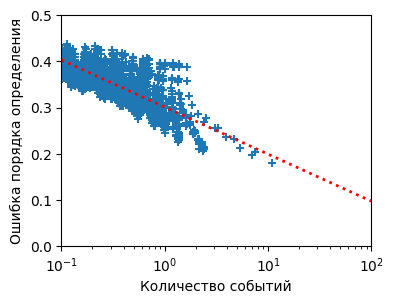

In [51]:
# error vs events
with h5py.File(train_h5_path, 'a') as f:
    ev_d = f['ev_dens'][:]
    mean_ev_d = np.mean(ev_d, axis=0)

print('relative error vs event num')
plot_error_vs_event_num(mean_ev_d, lognorm_sigma)

In [ ]:
# events fo gif
event_pics_for_gif(ev, params)

In [ ]:
# TODO 1) done 2) done 3) net schema 4) done 5) wells schema 

### work things

In [50]:
net.print_summary()

AttributeError: 'TrainConfig' object has no attribute 'input_shape'

In [16]:
# just for testing
x = torch.randn(2, 1100, 21**3) # embed shape batch size = 2

event_num = 1100
small_cube_side = 21

upconv_1 = nn.ConvTranspose3d(event_num, 256, kernel_size = 3, stride = 1, padding = 0, output_padding = 0)
upconv_2 = nn.ConvTranspose3d(256, 32, kernel_size = 3, stride = 1,  padding = 0, output_padding = 0)
upconv_3 = nn.ConvTranspose3d(32, 16, kernel_size = 3, stride = 1,  padding = 0, output_padding = 0)
upconv_4 = nn.ConvTranspose3d(16, 8, kernel_size = 3, stride = 1,  padding = 1, output_padding = 0)
upconv_5 = nn.ConvTranspose3d(8, 1, kernel_size = 3, stride = 1,  padding = 1, output_padding = 0)

bs = x.shape[0] # batch size
x = x.view(bs, -1, small_cube_side, small_cube_side, small_cube_side) # small cubes
print(x.shape, x.view(2,-1).shape) # 29700
x = upconv_1(x)
print(x.shape, x.view(2,-1).shape)
x = upconv_2(x)
print(x.shape, x.view(2,-1).shape)
x = upconv_3(x)
print(x.shape, x.view(2,-1).shape)
x = upconv_4(x)
print(x.shape, x.view(2,-1).shape)
x = upconv_5(x)
print(x.shape, x.view(2,-1).shape)

torch.Size([2, 1100, 21, 21, 21]) torch.Size([2, 10187100])
torch.Size([2, 256, 23, 23, 23]) torch.Size([2, 3114752])
torch.Size([2, 32, 25, 25, 25]) torch.Size([2, 500000])
torch.Size([2, 16, 27, 27, 27]) torch.Size([2, 314928])
torch.Size([2, 8, 27, 27, 27]) torch.Size([2, 157464])
torch.Size([2, 1, 27, 27, 27]) torch.Size([2, 19683])
